In [149]:
import torch
import functions_data
import os 
import functions_ordinal
import functions_plotting
import seaborn as sns
import matplotlib.pyplot as plt 
from torch import optim
import tqdm
from scipy.stats import entropy
import pandas as pd 

from functions_test_manipulations import get_merged_test_and_dict, get_dictionary, get_large_dataset
import numpy as np 

## Functions

In [82]:
# select the number of students to train question parameters (and student parameters - for old students)
def convert_dataframe_to_triples(data):
    """
    input - data: dataframe of dimensions n_students x n_questions 
    returns tensor of dimensions ((n_students*n_questions), 3)
    where first n_questions rows correspond to student 1, next n_questions rows correspond to student 3, etc. 
    """
    data = data.astype('float')
    data_tensor = torch.tensor(data.values)
    n_students, n_questions = data_tensor.shape[0], data_tensor.shape[1]

    data_tensor = data_tensor.reshape(-1)

    student_id = torch.arange(1, n_students + 1)
    student_id = student_id.repeat_interleave(n_questions)

    questions_in_order = data.columns
    question_id = []
    for q in questions_in_order:
        question_id.append(int(q[1:]))

    question_id = torch.tensor(question_id)
    
    # question_id = torch.arange(1, n_questions + 1)
    question_id = question_id.repeat(n_students)
    return torch.stack((student_id, question_id, data_tensor), dim=1)




def reveal_data(revealed_data, hidden_data, bs, bq0, rho, max_score, revealed_max_scores, hidden_max_scores):
    # data from which to choose 1 most uncertain question per student 
    prob_matrix = functions_ordinal.generate_prob_matrix(hidden_data, bs, bq0, rho, max_score, hidden_max_scores).detach()
    entropies = entropy(prob_matrix.T)

    # convert to dataframe and add fourth column for the entropy 
    df = pd.DataFrame(hidden_data.numpy(), columns=['studentID', 'questionID', 'score'])
    df['entropy'] = entropies

    # get the most uncertain question for each student to be revealed (uncertainty quantified by highest entropy for the distribution for a particular student)
    idx = df.groupby(['studentID'])['entropy'].transform(max) == df['entropy']

    # most uncertain question for each student, indices, all revealed indices so far
    reveal_indices = list(df[idx].index)

    # get hidden indices 
    set_reveal_indices = set(reveal_indices)
    set_all_indices = set(list(np.arange(0, hidden_data.shape[0], 1)))
    set_hide_indices = set_all_indices - set_reveal_indices
    hide_indices = list(set_hide_indices)

    revealed_data = torch.cat((revealed_data, hidden_data[reveal_indices]), 0)
    hidden_data = hidden_data[hide_indices]
    revealed_max_scores = torch.cat((revealed_max_scores, hidden_max_scores[reveal_indices]), 0)
    hidden_max_scores = hidden_max_scores[hide_indices]

    return revealed_data, revealed_max_scores, hidden_data, hidden_max_scores


def random_reveal_data(revealed_data, hidden_data, bs, bq0, rho, max_score, revealed_max_scores, hidden_max_scores):

    # convert to dataframe and add fourth column for the entropy 
    df = pd.DataFrame(hidden_data.numpy(), columns=['studentID', 'questionID', 'score'])

    # select random question for each student 
    sampled = df.groupby('studentID').sample(n=1, random_state=1)
    reveal_indices = sampled.index.values 

    # get hidden indices 
    set_reveal_indices = set(reveal_indices)
    set_all_indices = set(list(np.arange(0, hidden_data.shape[0], 1)))
    set_hide_indices = set_all_indices - set_reveal_indices
    hide_indices = list(set_hide_indices)

    revealed_data = torch.cat((revealed_data, hidden_data[reveal_indices]), 0)
    hidden_data = hidden_data[hide_indices]
    revealed_max_scores = torch.cat((revealed_max_scores, hidden_max_scores[reveal_indices]), 0)
    hidden_max_scores = hidden_max_scores[hide_indices]

    return revealed_data, revealed_max_scores, hidden_data, hidden_max_scores

    

def retrain_parameters(data, data_max_scores, bs_pool, bq0_pool, rho_pool, max_score, loss_, it):
    if it < 10:
        iterations = 1000
    else: 
        iterations = 100
    bq0_pool.requires_grad = False 
    rho_pool.requires_grad = False
    params = [bs_pool, bq0_pool, rho_pool]
    opt = optim.SGD(params, lr = 0.0001)
    n = data.shape[0]

    for iter in range(iterations):
        loss = functions_ordinal.nll(data, params, max_score, data_max_scores)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_.append(loss/n)
    
    return bs_pool, loss_




## Load data for all three exams 

In [161]:
_, meta_dict = get_large_dataset()

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_test_manipulations.py:135: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_filepath, index_col=0)


In [162]:
test_names = ['9to1_Edexcel_GCSE_Nov2018_1H', '9to1_Edexcel_GCSE_Nov2018_2H', 
'9to1_Edexcel_GCSE_Nov2018_3H']
data, questions_info, IDs  = get_merged_test_and_dict(test_names)

/Users/anastasijailic/Library/Mobile Documents/com~apple~CloudDocs/Master/functions_test_manipulations.py:98: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_filepath, index_col=0)


In [163]:
third_exam_dict = get_dictionary(meta_dict, test_names[-1])

In [164]:
# data_path = os.path.join(os.getcwd(), 'data', 'three_exams_cleaned.csv')
# dict_path = os.path.join(os.getcwd(), 'data', 'questions_info_dict.p')
# data, questions_info = functions_data.load_data_and_dictionary(data_path, dict_path)

n_students, n_questions = data.shape[0], data.shape[1]

# if the score is higher than max score for the given question, put score = max_score 
for col in data:
    m = questions_info[col]['Max']
    data[col].loc[data[col] > m] = m

# rename keys in the questions_info 
new_dictionary = {}
columns_mapper = {}
dict_keys = questions_info.keys()
for ind, key_old in enumerate(dict_keys):
    key_new = 'q' + str(ind + 1)
    new_dictionary[key_new] = questions_info[key_old]
    columns_mapper[key_old] = key_new 

# rename column in the dataframe
data = data.rename(columns=columns_mapper)

max_score = int(data.values.max())

In [165]:
print(data.shape)

(13963, 88)


In [166]:
# Separate learning and pooling dataframe 
# training_students = 13563
training_students = int(0.7*data.shape[0])
pooling_students = data.shape[0] - training_students

training_dataframe = data[:training_students]
pooling_dataframe = data[training_students:]

In [167]:
print(training_dataframe.shape)
print(pooling_dataframe.shape)

(9774, 88)
(4189, 88)


#  Pretrain parameters for the training dataset 

In [168]:
n_students, n_questions = training_dataframe.shape[0], training_dataframe.shape[1]

training_tensor = torch.tensor(training_dataframe.astype('float').values)
max_score = int(training_tensor.max().numpy())
train_data, validation_data, test_data = functions_ordinal.separate_train_validation_test_data(training_tensor)

train_data_max_scores = functions_ordinal.generate_max_scores_tensor(train_data, questions_info)
test_data_max_scores = functions_ordinal.generate_max_scores_tensor(test_data, questions_info)
validation_data_max_scores = functions_ordinal.generate_max_scores_tensor(validation_data, questions_info)

# initialization of parameters 
bs_pretrained = torch.randn(n_students, requires_grad=True)
bq0_pretrained = torch.distributions.uniform.Uniform(0,1).sample([n_questions,])
rho_pretrained = torch.normal(0, 0.1, size = (n_questions, max_score - 1), requires_grad=True) # rho1, rho2, rho3 

bq0_pretrained.requires_grad = True  


nlls_train = []
nlls_validation = []
nlls_test = []

iterations = 4000
params = [bs_pretrained, bq0_pretrained, rho_pretrained]

In [169]:
opt = optim.SGD(params, lr = 0.0001)

for iter in range(iterations):
    loss = functions_ordinal.nll(train_data, params, max_score, train_data_max_scores)    
    opt.zero_grad()
    loss.backward()
    opt.step()
    nlls_train.append(loss.detach().numpy())

    loss_validation = functions_ordinal.nll(validation_data, params, max_score, validation_data_max_scores)
    loss_test = functions_ordinal.nll(test_data, params, max_score, test_data_max_scores)

    nlls_validation.append(loss_validation.detach().numpy())
    nlls_test.append(loss_test.detach().numpy())

    if iter % 100 == 0:
        print(iter)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900


## Load pretrained parameters on the training dataset 

In [170]:
# # load trained parameters after 1000 iterations for the training data pool in active learning 

# bs_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', '1000iters_bs.pth'))
# bq0_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', '1000iters_bq0.pth'))
# rho_pretrained = torch.load(os.path.join(os.getcwd(), 'al_params', '1000iters_rho.pth'))

## Separate learning pool and testing pool for active learning


In [171]:
questions = list(pooling_dataframe.columns)
n_questions_third_test = len(third_exam_dict)
n_questions_first_second_test = n_questions - n_questions_third_test
learning_questions = questions[:n_questions_first_second_test]
testing_questions = questions[n_questions_first_second_test:] # testing questions are now the entire exam (third one)

# number of questions in the learning pool and testing pool 
n_learning_pool = len(learning_questions)
n_testing_pool = len(testing_questions)

In [172]:
learning_pool_df = pooling_dataframe[learning_questions]
testing_pool_df = pooling_dataframe[testing_questions]

learning_pool = convert_dataframe_to_triples(learning_pool_df)
testing_pool = convert_dataframe_to_triples(testing_pool_df)

In [173]:
learning_pool_max_scores = functions_ordinal.generate_max_scores_tensor(learning_pool, new_dictionary)
testing_pool_max_scores = functions_ordinal.generate_max_scores_tensor(testing_pool, new_dictionary)

## Retrain parameters on the entire learning pool 

In [174]:
print(pooling_students)
print(learning_pool_df.shape[0])
print(n_learning_pool, learning_pool_df.shape[1])

4189
4189
58 58


In [175]:
# number of students in the learning pool 
S_learning_pool = pooling_students # could also be init as learning_pool_df.shape[0]
Q_learning_pool = n_learning_pool # learning_pool_df.shape[0]

bs_pool = torch.randn(S_learning_pool, requires_grad=True)
# bs_pool = torch.repeat_interleave(bs_pretrained.detach().mean(), S_learning_pool)
bs_pool.requires_grad = True
bq0_pool = bq0_pretrained.detach().clone()
rho_pool = rho_pretrained.detach().clone()


# calculate initial accuracy with randomly assigned bs 
active_learning_iterations = Q_learning_pool 
initial_accuracy = 0 

prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]

initial_accuracy = functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy()
print('Accuracy before training ', initial_accuracy)

# def retrain_parameters(data, data_max_scores, bs_pool, bq0_pool, rho_pool, max_score, loss_, it):
iterations = 5000 

bq0_pool.requires_grad = False 
rho_pool.requires_grad = False

params = [bs_pool, bq0_pool, rho_pool]
opt = optim.SGD(params, lr = 0.0001)
n = learning_pool.shape[0]
loss_random_init = []
accuracies_random_init = []

for iter in range(iterations):
    loss = functions_ordinal.nll(learning_pool, params, max_score, learning_pool_max_scores)
    opt.zero_grad()
    loss.backward()
    opt.step()
    loss_random_init.append(loss/n)


    prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
    predicted_scores = prob_matrix.argmax(axis = 1)
    true_scores = testing_pool[:, 2]
    
    accuracies_random_init.append(functions_ordinal.full_accuracy(true_scores, predicted_scores).numpy())

    if iter % 100 == 0:
        print(iter, loss)


Accuracy before training  0.5936739
0 tensor(248783.8750, grad_fn=<NegBackward0>)
100 tensor(236971.5625, grad_fn=<NegBackward0>)
200 tensor(227308.0312, grad_fn=<NegBackward0>)
300 tensor(219473.7812, grad_fn=<NegBackward0>)
400 tensor(213171.0156, grad_fn=<NegBackward0>)
500 tensor(208131.3125, grad_fn=<NegBackward0>)
600 tensor(204120.2812, grad_fn=<NegBackward0>)
700 tensor(200937.8906, grad_fn=<NegBackward0>)
800 tensor(198417.6250, grad_fn=<NegBackward0>)
900 tensor(196422.9688, grad_fn=<NegBackward0>)
1000 tensor(194843.8750, grad_fn=<NegBackward0>)
1100 tensor(193592.3750, grad_fn=<NegBackward0>)
1200 tensor(192598.8594, grad_fn=<NegBackward0>)
1300 tensor(191808.4844, grad_fn=<NegBackward0>)
1400 tensor(191178.2031, grad_fn=<NegBackward0>)
1500 tensor(190674.1875, grad_fn=<NegBackward0>)
1600 tensor(190270.0156, grad_fn=<NegBackward0>)
1700 tensor(189944.9062, grad_fn=<NegBackward0>)
1800 tensor(189682.5781, grad_fn=<NegBackward0>)
1900 tensor(189470.2031, grad_fn=<NegBackward

Text(0.5, 1.0, 'Training for new students in the learning pool')

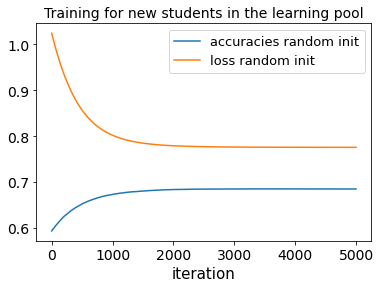

In [176]:
loss_random_init = [x.detach().numpy() for x in loss_random_init]
plt.plot(accuracies_random_init, label ='accuracies random init')
plt.plot(loss_random_init, label = 'loss random init')

# plt.plot(accuracies_mean_bs_initialisation, label ='accuracies mean init')
# plt.plot(loss_mean_bs_init, label = 'loss mean init')

plt.legend(fontsize=13)
plt.xlabel('iteration', size = 15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Training for new students in the learning pool', fontsize=14)

## Mean prediction for each student on the heldout exam

In [177]:
prob_matrix = functions_ordinal.generate_prob_matrix(testing_pool, bs_pool, bq0_pool, rho_pool, max_score, testing_pool_max_scores)
predicted_scores = prob_matrix.argmax(axis = 1)
true_scores = testing_pool[:, 2]
scores_matrix = torch.tensor(list(np.arange(0, max_score + 1, 1))).repeat(prob_matrix.shape[0], 1)
expected_value_matrix = torch.mul(prob_matrix, scores_matrix) 
predicted_expected_value_scores = expected_value_matrix.sum(axis = 1)

In [178]:
df = pd.DataFrame(testing_pool.numpy(), columns=['studentID', 'questionID', 'score'])
df['thresh_predicted_score'] = predicted_scores
df['mean_predicted_score'] = predicted_expected_value_scores.detach().numpy()

df_sum = df.groupby(['studentID']).sum()

In [179]:
print('Accuracy on the testing pool ', (df['thresh_predicted_score'] == df['score']).astype(int).sum()/df.shape[0])

Accuracy on the testing pool  0.6851277154452137


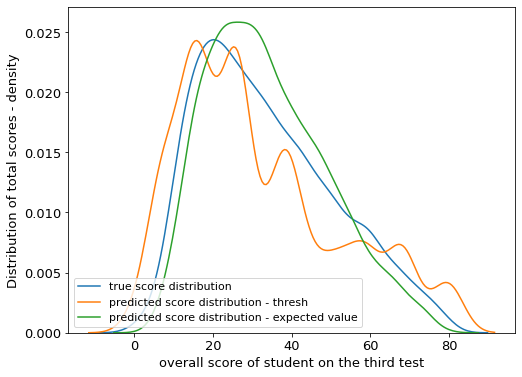

In [180]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df_sum.score, label = 'true score distribution')
sns.kdeplot(df_sum.thresh_predicted_score, label = 'predicted score distribution - thresh')
sns.kdeplot(df_sum.mean_predicted_score, label = 'predicted score distribution - expected value')
plt.legend(fontsize = 11)
plt.xlabel('overall score of student on the third test', fontsize = 13)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel('Distribution of total scores - density', fontsize = 13)
plt.show()

In [181]:
df_sum = df_sum[['score', 'thresh_predicted_score', 'mean_predicted_score']]

In [182]:
df_sum['diff_mean'] = abs(df_sum['score'] - df_sum['mean_predicted_score'])
df_sum['diff_thresh'] = abs(df_sum['score'] - df_sum['thresh_predicted_score'])

In [183]:
print(df_sum['diff_thresh'].mean())
print(df_sum['diff_mean'].mean())

7.335163523513965
5.934085520618882


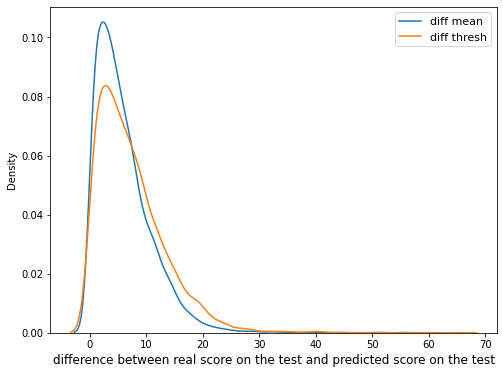

In [184]:
plt.figure(figsize=(8, 6))
sns.kdeplot(df_sum.diff_mean, label = 'diff mean')
sns.kdeplot(df_sum.diff_thresh, label = 'diff thresh')
plt.legend(fontsize = 11)
plt.xlabel('difference between real score on the test and predicted score on the test', size = 12)
plt.show()

## Compare true and predicted scores 

In [185]:
true_scores = torch.tensor(df_sum['score'].values)
student_ids = df_sum.index.to_numpy()
predicted_scores = torch.tensor(df_sum['mean_predicted_score'].values)
diff = true_scores - predicted_scores
n_students_selected = 5000
plt.figure(figsize=(8, 6))
plt.scatter(predicted_scores, true_scores, color='skyblue')
plt.xlabel('predicted score', size = 15)
plt.ylabel('true score', size = 15)
x = np.arange(0,80)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x-15, color = 'b')
plt.plot(x, x+15, color = 'b', label = r'$x \pm 20$')
plt.legend()

plt.title('Third exam prediction of total score for each student', size=15)
plt.show()

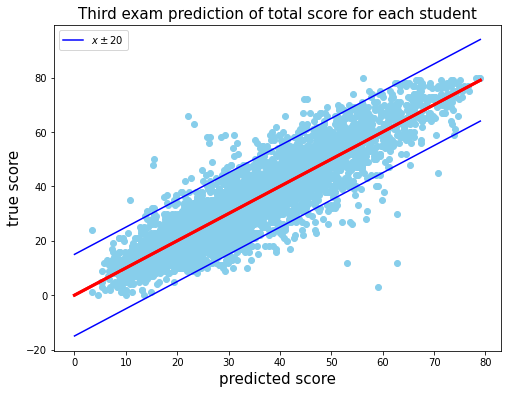

In [186]:
n_students_selected = 5000
plt.figure(figsize=(8, 6))
plt.scatter(predicted_scores, true_scores, color='skyblue')
plt.xlabel('predicted score', size = 15)
plt.ylabel('true score', size = 15)
x = np.arange(0,80)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x-15, color = 'b')
plt.plot(x, x+15, color = 'b', label = r'$x \pm 20$')
plt.legend()

plt.title('Third exam prediction of total score for each student', size=15)
plt.show()

## Find outliers 

In [187]:
df = pd.DataFrame()
df['trueScore'] = true_scores
df['predictedScore'] = predicted_scores
df['difference'] = diff
df['studentID'] = student_ids.astype(int)
df['absDifference'] = abs(diff)

In [188]:
df_ones_true_scores = df[df['trueScore'] == 1]
df_ones_true_scores = df_ones_true_scores[df_ones_true_scores['difference'] < -20]

print(df_ones_true_scores.shape)
students_outliers_ids = df_ones_true_scores['studentID'].values
print(students_outliers_ids - 1)

(0, 5)
[]


In [189]:
df_removed_outliers = df.drop(students_outliers_ids - 1)
df_removed_outliers['absDifference'] = abs(df_removed_outliers['difference'])

In [190]:
print(df_removed_outliers['absDifference'].mean())
print(df['absDifference'].mean())

5.934085520618882
5.934085520618882


In [191]:
tp_df = testing_pool_df.reset_index()
indices_to_look = np.arange(4121, 4200, 1)
print(tp_df.loc[indices_to_look])

KeyError: '[4189, 4190, 4191, 4192, 4193, 4194, 4195, 4196, 4197, 4198, 4199] not in index'

In [192]:
removed_outliers_true_scores = df_removed_outliers['trueScore']
removed_outliers_predicted_scores = df_removed_outliers['predictedScore']

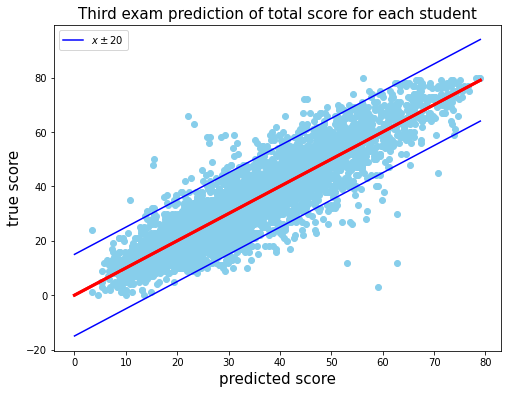

In [193]:
n_students_selected = 5000
plt.figure(figsize=(8, 6))
plt.scatter(removed_outliers_predicted_scores, removed_outliers_true_scores, color='skyblue')
plt.xlabel('predicted score', size = 15)
plt.ylabel('true score', size = 15)
x = np.arange(0,80)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x-15, color = 'b')
plt.plot(x, x+15, color = 'b', label = r'$x \pm 20$')
plt.legend()

plt.title('Third exam prediction of total score for each student', size=15)
plt.show()

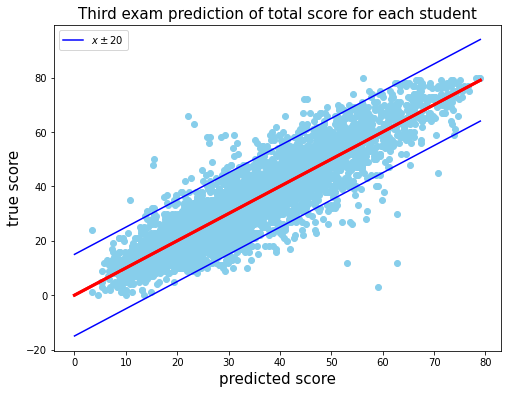

In [194]:
n_students_selected = 5000
plt.figure(figsize=(8, 6))
plt.scatter(predicted_scores, true_scores, color='skyblue')
plt.xlabel('predicted score', size = 15)
plt.ylabel('true score', size = 15)
x = np.arange(0,80)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x, color='r', linewidth = 3)
plt.plot(x, x-15, color = 'b')
plt.plot(x, x+15, color = 'b', label = r'$x \pm 20$')
plt.legend()

plt.title('Third exam prediction of total score for each student', size=15)
plt.show()

In [109]:
print(predicted_scores.shape)
print(true_scores.shape)

torch.Size([5305])
torch.Size([5305])
